In [1]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model_batch_culture import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 20000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
#xS0 = 4.180555555555556e+21
M0 = 1e8 

Defining the system topology parameters

In [3]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [4]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [5]:
wE = 20; wEp = 20; wTF = 20; wpTox = 2;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 12, 13]] = [wE, wEp, wTF, wpTox, K_E, K_pTox]

param_indices = [2]             # e.g., wEp at index 2 (old behaviour)
# param_indices = [2, 3, 12]    # Example: optimize wEp, wTF, K_E
lower_bounds  = [0]             # lower bounds for each parameter
upper_bounds  = [100]           # upper bounds

n_params = len(param_indices)

Writing a wrapper to take wEp and return the productivity and yield

In [6]:
def evaluate_model(x_vector):
    xPR_local = xPR.copy()
    for idx, value in zip(param_indices, x_vector):
        xPR_local[idx] = value

    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

    return -np.log(vP), -np.log(pY)

Setting up the optimisation problems

In [7]:
class SingleObjective(ElementwiseProblem):
    def __init__(self, obj_id):
        super().__init__(n_var=n_params,
                         n_obj=1,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.obj_id = obj_id

    def _evaluate(self, x, out, **kwargs):
        obj_vec = evaluate_model(x)
        out["F"] = obj_vec[self.obj_id]


class MultiObjectiveScaled(ElementwiseProblem):
    def __init__(self, scale):
        super().__init__(n_var=n_params,
                         n_obj=2,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.scale = scale

    def _evaluate(self, x, out, **kwargs):
        vP_log, pY_log = evaluate_model(x)
        out["F"] = np.array([vP_log, pY_log]) / self.scale

Running the optimisation to find optimal vP

In [8]:
res_vP = minimize(
    SingleObjective(obj_id=0),
    GA(pop_size=30),
    seed=1,
    verbose=True
)
max_vP_log = res_vP.F[0]
print("Max vP:", np.exp(-max_vP_log))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -1.467166E+01 | -1.480075E+01
     2 |       60 | -1.479229E+01 | -1.480075E+01
     3 |       90 | -1.480019E+01 | -1.480075E+01
     4 |      120 | -1.480069E+01 | -1.480077E+01
     5 |      150 | -1.480075E+01 | -1.480077E+01
     6 |      180 | -1.480076E+01 | -1.480078E+01
     7 |      210 | -1.480076E+01 | -1.480078E+01
     8 |      240 | -1.480077E+01 | -1.480078E+01
     9 |      270 | -1.480077E+01 | -1.480078E+01
    10 |      300 | -1.480078E+01 | -1.480078E+01
    11 |      330 | -1.480078E+01 | -1.480078E+01
    12 |      360 | -1.480078E+01 | -1.480078E+01
    13 |      390 | -1.480078E+01 | -1.480078E+01
    14 |      420 | -1.480078E+01 | -1.480078E+01
    15 |      450 | -1.480078E+01 | -1.480078E+01
    16 |      480 | -1.480078E+01 | -1.480078E+01
    17 |      510 | -1.480078E+01 | -1.480078E+01
    18 |      540 | -1.480078E+01 | -1.480078E+01
    19 |      570 | -1.480078E+01 | -1.480078E+01


Running the optimisation to find optimisal pY

In [9]:
res_pY = minimize(
    SingleObjective(obj_id=1),
    GA(pop_size=30),
    seed=1,
    verbose=True
)
max_pY_log = res_pY.F[0]
print("Max pY:", np.exp(-max_pY_log))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  2.935916E+01 |  2.852790E+01
     2 |       60 |  2.872708E+01 |  2.851716E+01
     3 |       90 |  2.853661E+01 |  2.851000E+01
     4 |      120 |  2.851919E+01 |  2.850974E+01
     5 |      150 |  2.851121E+01 |  2.850947E+01
     6 |      180 |  2.850984E+01 |  2.850938E+01
     7 |      210 |  2.850949E+01 |  2.850938E+01
     8 |      240 |  2.850941E+01 |  2.850938E+01
     9 |      270 |  2.850938E+01 |  2.850938E+01
    10 |      300 |  2.850938E+01 |  2.850938E+01
    11 |      330 |  2.850938E+01 |  2.850938E+01
    12 |      360 |  2.850938E+01 |  2.850938E+01
    13 |      390 |  2.850938E+01 |  2.850938E+01
    14 |      420 |  2.850938E+01 |  2.850938E+01
    15 |      450 |  2.850938E+01 |  2.850938E+01
    16 |      480 |  2.850938E+01 |  2.850938E+01
    17 |      510 |  2.850938E+01 |  2.850938E+01
    18 |      540 |  2.850938E+01 |  2.850938E+01
    19 |      570 |  2.850938E+01 |  2.850938E+01


Running the multiobjective optimisation

In [10]:
scale = np.array([abs(max_vP_log), abs(max_pY_log)])
termination = get_termination("n_gen", 80)
res = minimize(
    MultiObjectiveScaled(scale),
    NSGA2(pop_size=60),
    termination,
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |     30 |             - |             -
     2 |      120 |     60 |  0.0176120079 |         ideal
     3 |      180 |     60 |  0.0106164800 |         ideal
     4 |      240 |     60 |  0.0052285844 |             f
     5 |      300 |     60 |  0.0048069577 |         nadir
     6 |      360 |     60 |  0.0023682586 |             f
     7 |      420 |     60 |  0.0048188099 |             f
     8 |      480 |     60 |  0.0038862091 |             f
     9 |      540 |     60 |  0.0025699682 |             f
    10 |      600 |     60 |  0.0034867919 |             f
    11 |      660 |     60 |  0.0034497759 |             f
    12 |      720 |     60 |  0.0040324820 |             f
    13 |      780 |     60 |  0.0036544875 |             f
    14 |      840 |     60 |  0.0029840260 |             f
    15 |      900 |     60 |  0.0033256891 |             f
    16 |      960 |     60 |  0.0030549090 |            

Extracting the pareto front

In [11]:
pareto_X = res.X                          # parameter sets
pareto_scaled = res.F                     # scaled objectives
pareto_unscaled = pareto_scaled * scale   # real objectives

vP_vals = np.exp(-pareto_unscaled[:, 0])
pY_vals = np.exp(-pareto_unscaled[:, 1])

print("Pareto points:", len(vP_vals))

Pareto points: 60


In [13]:
print(pareto_X)

[[53.198571  ]
 [99.99999997]
 [80.08312459]
 [83.98073647]
 [82.27758353]
 [74.82405469]
 [70.36867294]
 [65.5741333 ]
 [99.12871958]
 [78.90994685]
 [81.29726678]
 [84.58529749]
 [95.11744844]
 [71.61251888]
 [76.14821161]
 [96.07413313]
 [93.75561559]
 [60.36004962]
 [85.26915184]
 [64.57481587]
 [89.39640298]
 [54.74723359]
 [85.9520855 ]
 [58.28365467]
 [73.80616956]
 [98.18430349]
 [77.74572803]
 [72.04566468]
 [86.87827435]
 [93.11864817]
 [59.32130655]
 [66.32967136]
 [67.01916469]
 [72.89111393]
 [69.8920375 ]
 [87.72493231]
 [54.14458725]
 [90.99171174]
 [81.7811563 ]
 [86.92652393]
 [88.0277333 ]
 [74.01288494]
 [59.509472  ]
 [78.32108662]
 [94.81171416]
 [62.23451804]
 [57.37224366]
 [72.84311077]
 [56.69000611]
 [99.6582872 ]
 [88.73747165]
 [67.69406537]
 [64.02871588]
 [55.75285779]
 [68.88277082]
 [97.69513551]
 [67.88613328]
 [90.32884045]
 [90.04788804]
 [76.70561047]]


Now plotting the pareto front

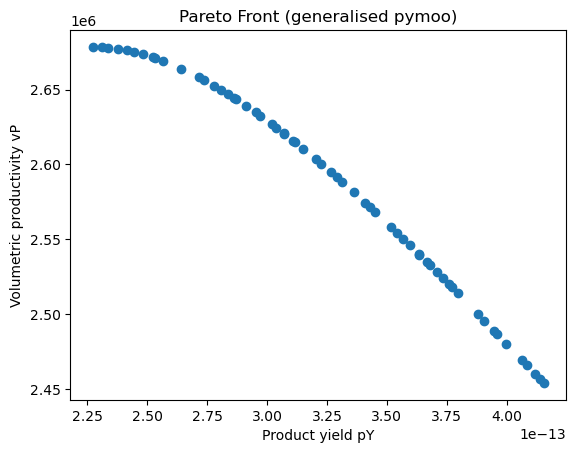

In [12]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield pY")
plt.ylabel("Volumetric productivity vP")
plt.title("Pareto Front (generalised pymoo)")
plt.show()